# Setup

## Imports

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px

# Machine Learning
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans

# Ingesting Data

In [2]:
# List of report files
data_path = "../data/processed/rfm_standard.csv"

# Load data
df = pd.read_csv(data_path)

# Applying K-Means algorithm

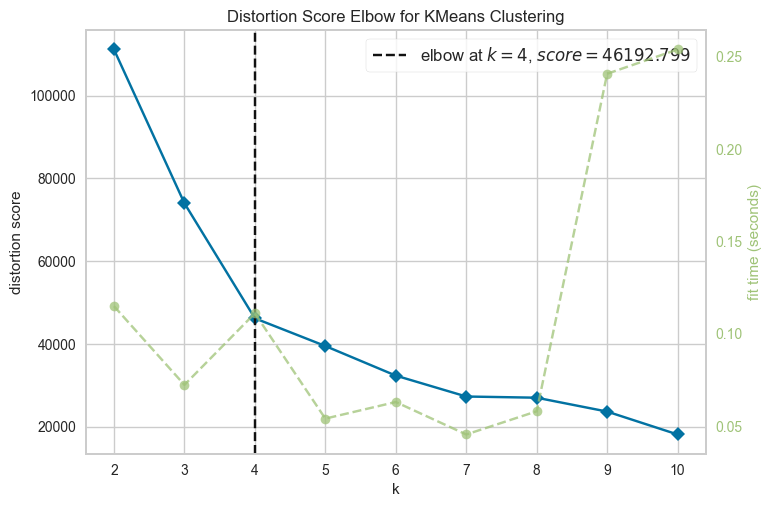

In [3]:
X = df.loc[:, ["R","F","M",]]
optimal_k_value = KElbowVisualizer(estimator=KMeans(random_state=42,), k=(2,11), metric="distortion",)
default_model = KMeans(n_clusters=optimal_k_value.fit(X).elbow_value_, random_state=42)
default_model.fit(X)
df = df.assign(rfm_default_clusters=default_model.labels_.astype(str))
optimal_k_value.show();

In [4]:
fig = px.scatter_3d(
    df, 
    x="recency", 
    y="frequency",
    z="monetary",
    color="rfm_default_clusters",
    opacity=0.8,
)

fig.update_traces(marker=dict(size=4))

fig.show()

## Notas

### Hipótese
1. A assimetria da distribuição de dados das três dimensões RFM (especialmente frequência e valor monetário) pode exigir uma técnica de transformação de distribuição de dados para o agrupamento.

### Evidências
1. A EDA realizada em [1.0-eda.ipynb](1.0-eda.ipynb) mostrou que a distribuição de dados é altamente enviesada, especialmente nas dimensões monetária e de recência. Esse enviesamento pode levar a resultados de agrupamento tendenciosos, onde certas dimensões dominam o processo.
2. A classificação RFM via o método de discretização por frequência igual em [2.0-rfm_default](2.0-rfm_default.ipynb) não conseguiu nem mesmo dividir a dimensão de frequência em 5 categorias, destacando o viés.
3. A análise visual realizada no gráfico de agrupamento revela que os clusters não estão bem definidos, e a dimensão de frequência não está sendo considerada no processo de agrupamento.

### Conclusões
1. Hipótese confirmada. Será testada uma técnica de transformação de distribuição de dados para melhorar os resultados de agrupamento. O valor do índice de distorção (também chamado SSE) do modelo atual é 46.142.

# Exporting Data

In [5]:
df.to_csv("../data/processed/rfm_kmeans.csv", index=False)